In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
#uvoz skupa podataka

df = pd.read_csv('../freMTPL2freq.csv')
df = df.sample(n=100000, random_state=42)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [3]:
df.shape

(100000, 12)

In [4]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [5]:
df.duplicated().sum() #nemamo duplikata u skupu

0

In [6]:
# izvaci redove gde je ClaimNb veca od 4
df = df[df['ClaimNb'] <= 4]

In [7]:
# Nova kolona: da li je vozač imao bar jednu štetu
df['ClaimNb'] = df['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
# Izbor karakteristika i enkodiranje kategorijskih atributa
# Ukloni IDpol i ClaimNb iz features
features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])


y = df['ClaimNb']

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

## Decison tree

In [11]:
# Kreiraj i treniraj stablo odlučivanja
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
# Evaluacija osnovnog stabla
y_pred = dtc.predict(X_test)
print("Osnovno stablo TEST:")
print(classification_report(y_test, y_pred))
print("Tačnost:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Osnovno stablo TEST:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     28501
           1       0.07      0.09      0.08      1499

    accuracy                           0.90     30000
   macro avg       0.51      0.51      0.51     30000
weighted avg       0.91      0.90      0.90     30000

Tačnost: 0.8972
[[26787  1714]
 [ 1370   129]]


In [13]:
print(f"Dubina stabla: {dtc.get_depth()}")

Dubina stabla: 67


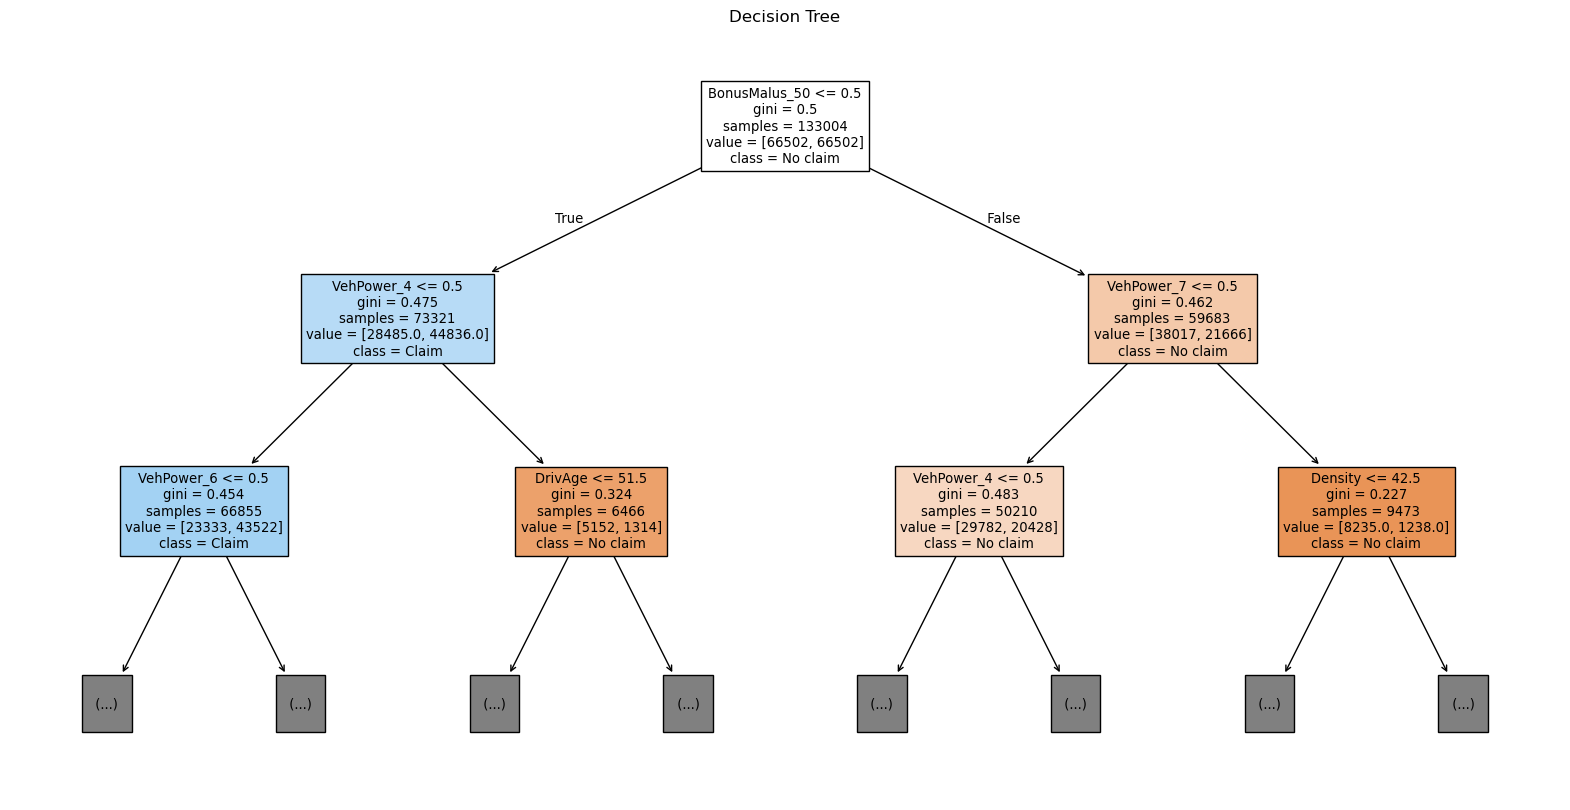

In [14]:
# Vizualizacija stabla
plt.figure(figsize=(20, 10))
plot_tree(dtc, feature_names=X.columns, class_names=["No claim", "Claim"], filled=True, max_depth=2)
plt.title("Decision Tree")
plt.show()

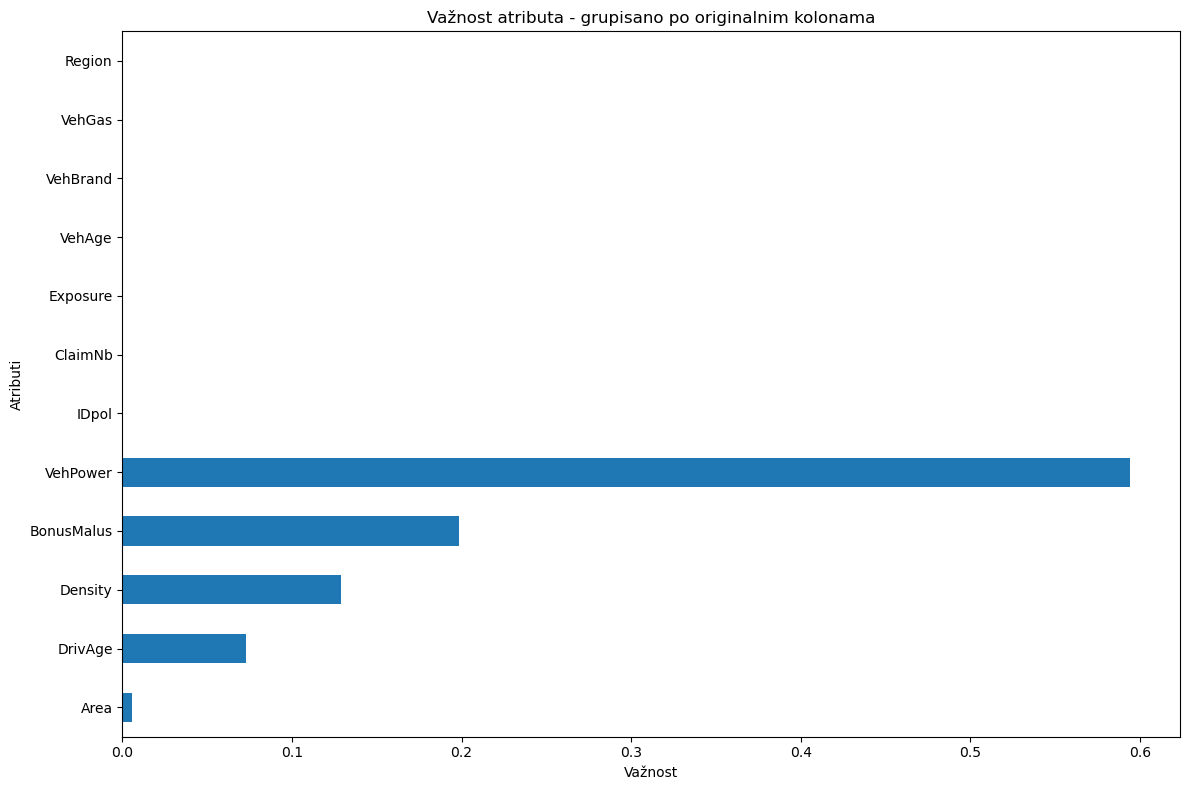

In [15]:
# Kreiramo mapiranje od dummya ka izvornom atributu
import re 
from collections import defaultdict

grouped_importances = defaultdict(float)
columns = X.columns
importances = dtc.feature_importances_

for col, imp in zip(columns, importances):
    # Pronađi osnovni atribut iz imena kolone
    base = re.split(r'[_\.]', col)[0]  # npr. "Region_11" -> "Region"
    grouped_importances[base] += imp

# Pretvaranje u seriju i prikaz
grouped_series = pd.Series(grouped_importances).reindex([
    'IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower',
    'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand',
    'VehGas', 'Density', 'Region'
])

# Crtanje grafika
plt.figure(figsize=(12, 8))
grouped_series.sort_values().plot.barh()
plt.title("Važnost atributa - grupisano po originalnim kolonama")
plt.xlabel("Važnost")
plt.ylabel("Atributi")
plt.tight_layout()
plt.show()

In [16]:
# GridSearch za optimizaciju
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [2, 4, 6]
}
estimator = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, cv=3,  scoring="f1", n_jobs=-1)
estimator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [5, 10, 15]},
             scoring='f1')

In [17]:
best_tree = estimator.best_estimator_

y_pred_optimized = best_tree.predict(X_test)
print("Tačnost optimizovanog modela test:", accuracy_score(y_test, y_pred_optimized))
print(confusion_matrix(y_test, y_pred_optimized))

Tačnost optimizovanog modela test: 0.9108333333333334
[[27228  1273]
 [ 1402    97]]


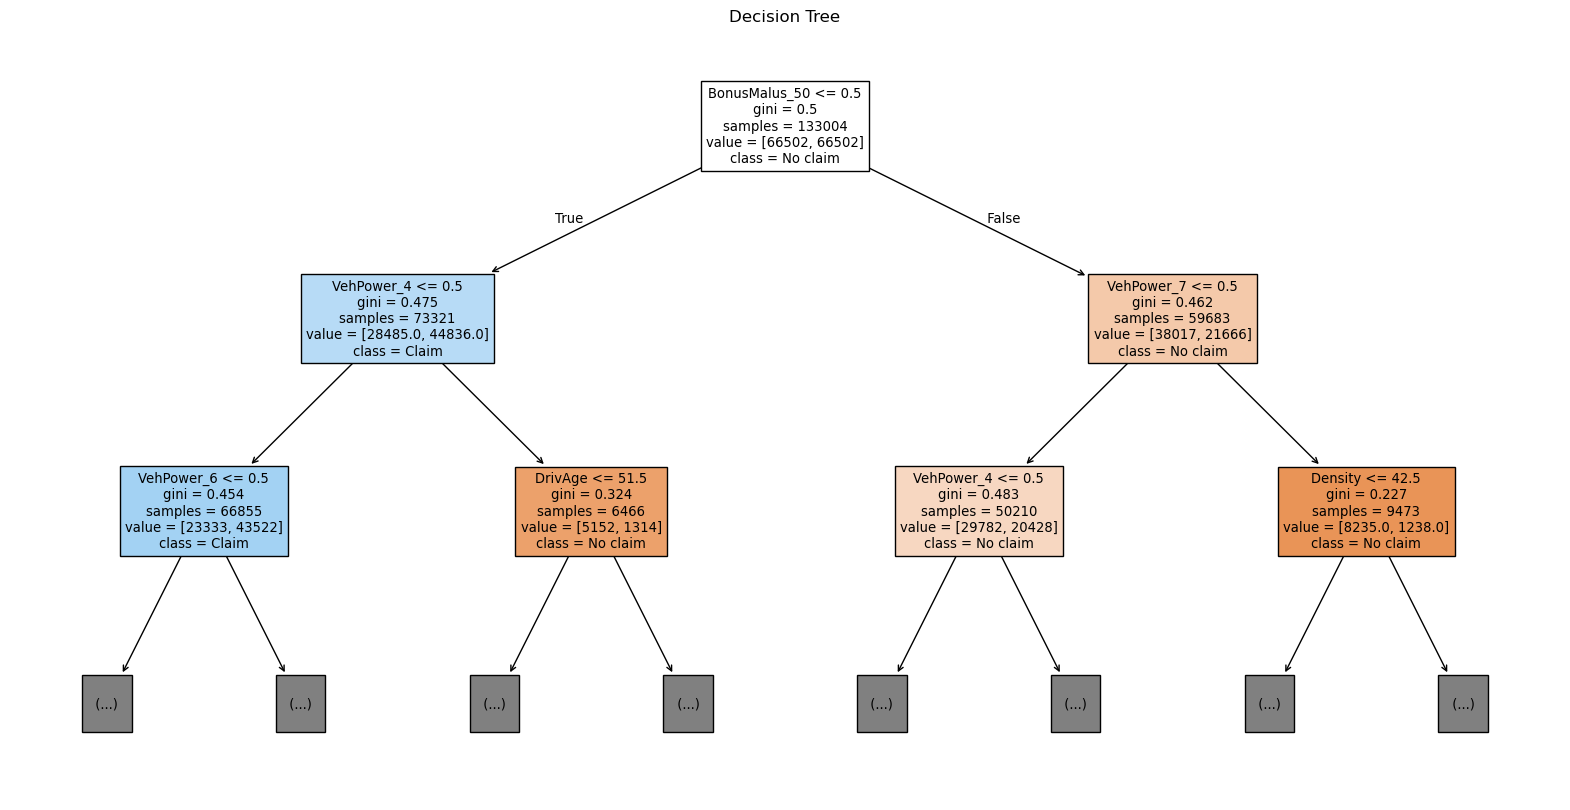

In [18]:
# Prikaz najboljeg stabla iz GridSearchCV
plt.figure(figsize=(20, 10))
plot_tree(
    estimator.best_estimator_,           # <- najbolji model
    feature_names=X.columns,             # <- imena kolona ako koristiš pandas DataFrame
    class_names=["No claim", "Claim"],   # <- nazivi klasa
    filled=True,
    max_depth=2
)
plt.title("Decision Tree")
plt.show()

In [19]:
# Evaluacija najboljeg modela
def report(model, X, y, dataset_name):
    y_pred = model.predict(X)
    print(f"\nClassification Report - {dataset_name}:")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    print(' Matrica konfuzije:')
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No claim", "Claim"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()


Classification Report - Training set:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     66502
           1       0.95      0.82      0.88     66502

    accuracy                           0.89    133004
   macro avg       0.90      0.89      0.89    133004
weighted avg       0.90      0.89      0.89    133004

 Matrica konfuzije:
[[63667  2835]
 [11904 54598]]


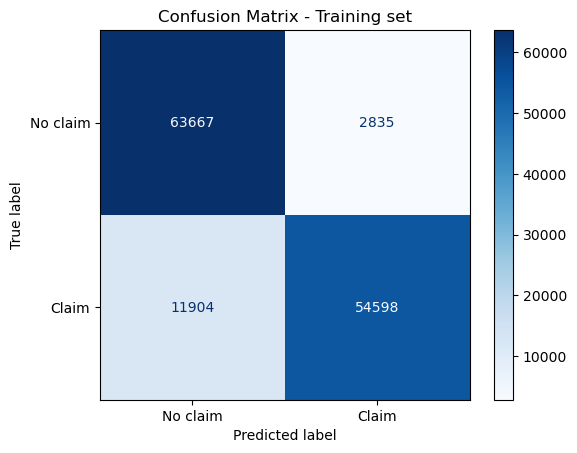


Classification Report - Test set:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     28501
           1       0.07      0.06      0.07      1499

    accuracy                           0.91     30000
   macro avg       0.51      0.51      0.51     30000
weighted avg       0.91      0.91      0.91     30000

 Matrica konfuzije:
[[27228  1273]
 [ 1402    97]]


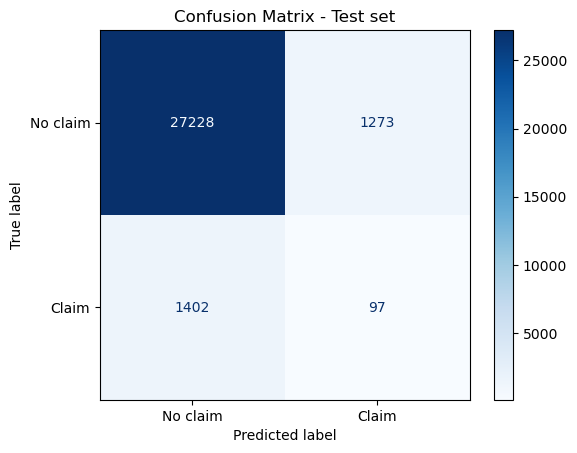

In [20]:
report(estimator.best_estimator_, X_train, y_train, "Training set")
report(estimator.best_estimator_, X_test, y_test, "Test set")

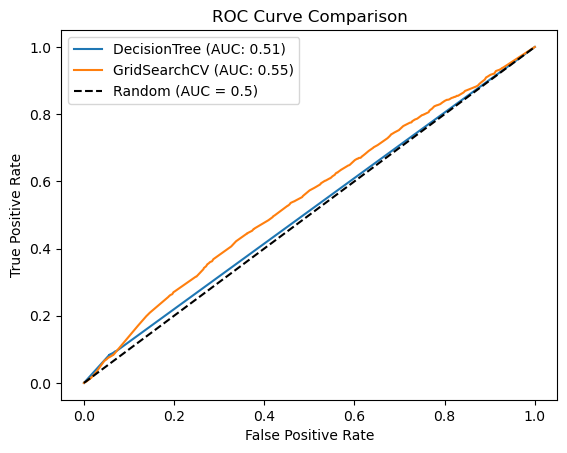

In [21]:
# ROC kriva za najbolji model
models = [dtc, estimator.best_estimator_]
model_names = ['DecisionTree', 'GridSearchCV']

for model, model_name in zip(models, model_names):
    # Dobijamo verovatnoće za klasu 1 (ili neku drugu koju želiš da posmatraš)
    y_score = model.predict_proba(X_test)[:, 1]  # kolona za klasu '1'
    fpr, tpr, _ = roc_curve(y_test == 1, y_score)
    auc = roc_auc_score(y_test == 1, y_score)
    label = f"{model_name} (AUC: {auc:.2f})"
    plt.plot(fpr, tpr, label=label)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

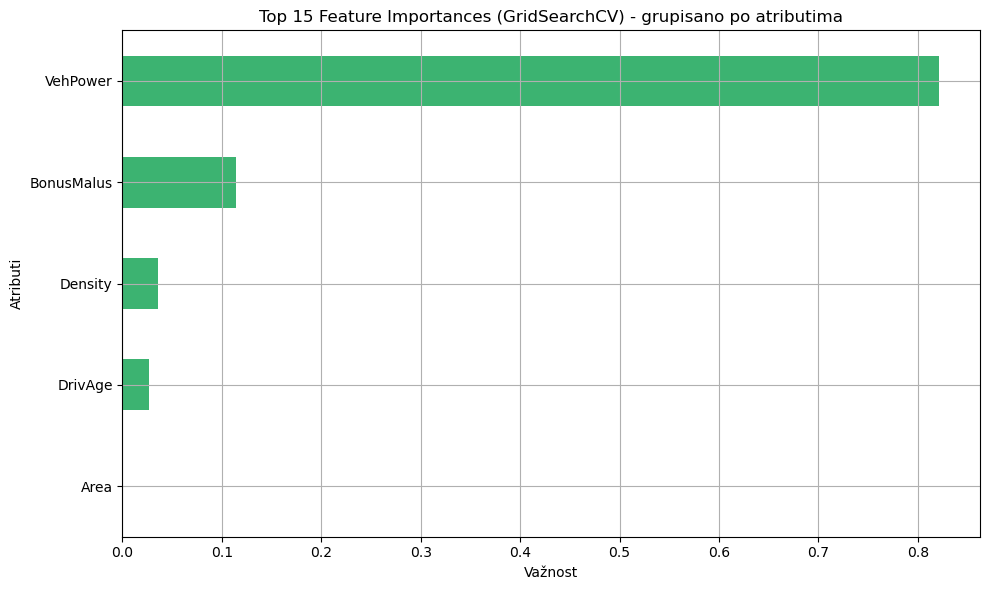

In [22]:
# Vizualizacija najvažnijih karakteristika kod optimizovanog stabla

# Uzimamo feature_importances_ iz optimizovanog modela (GridSearchCV)
importances = estimator.best_estimator_.feature_importances_
columns = X.columns

# Grupisanje važnosti po osnovnim atributima (prvi deo imena kolone)
grouped_importances = defaultdict(float)
for col, imp in zip(columns, importances):
    base = re.split(r'[_\.]', col)[0]  # npr. 'Region_11' -> 'Region'
    grouped_importances[base] += imp

# Pretvaranje u seriju i sortiranje po važnosti
fi_grouped = pd.Series(grouped_importances)
fi_sorted = fi_grouped.sort_values(ascending=False).head(15)

# Crtanje
plt.figure(figsize=(10, 6))
fi_sorted.plot.barh(color='mediumseagreen')
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (GridSearchCV) - grupisano po atributima")
plt.xlabel("Važnost")
plt.ylabel("Atributi")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11612\3032430122.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_claim_rate = df.groupby("AgeGroup")["ClaimNb"].mean()


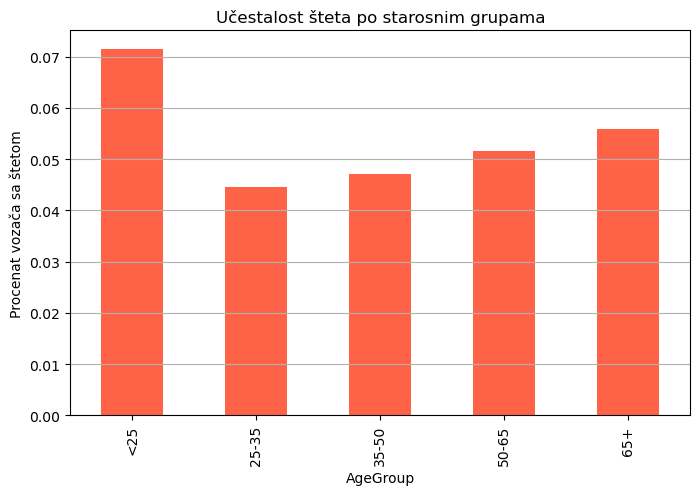

In [23]:
# Dodatna analiza: Kako se verovatnoća štete menja sa starošću?
df["AgeGroup"] = pd.cut(df["DrivAge"], bins=[17, 25, 35, 50, 65, 100], labels=["<25", "25-35", "35-50", "50-65", "65+"])
avg_claim_rate = df.groupby("AgeGroup")["ClaimNb"].mean()

plt.figure(figsize=(8, 5))
avg_claim_rate.plot(kind="bar", color="tomato")
plt.ylabel("Procenat vozača sa štetom")
plt.title("Učestalost šteta po starosnim grupama")
plt.grid(axis="y")
plt.show()

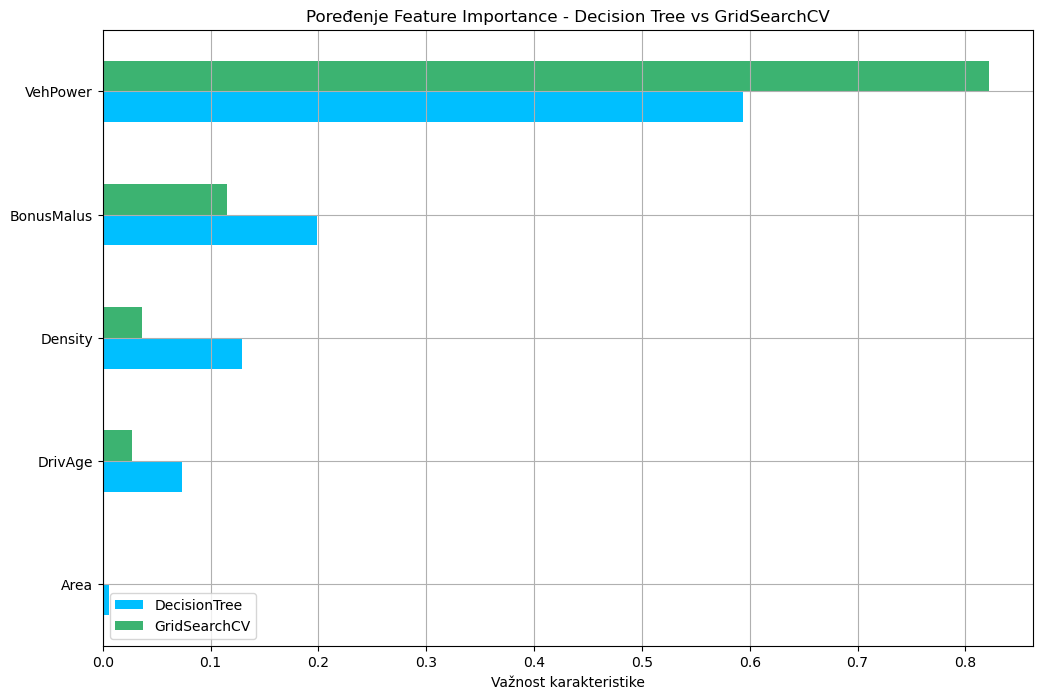

In [24]:
# Feature importance za oba modela
# Funkcija za vraćanje "osnovnog" imena kolone (pre _)
def get_base_feature(col_name):
    return col_name.split('_')[0] if '_' in col_name else col_name

# Mapiranje kolona na bazne kategorije
base_features = X.columns.map(get_base_feature)

# Decision Tree feature importance - grupisano po baznim kolonama
fi_dtc_grouped = pd.Series(dtc.feature_importances_, index=base_features).groupby(level=0).sum()

# GridSearchCV feature importance - grupisano
fi_grid_grouped = pd.Series(estimator.best_estimator_.feature_importances_, index=base_features).groupby(level=0).sum()

# Spajanje u jedan DataFrame
fi_df = pd.DataFrame({'DecisionTree': fi_dtc_grouped, 'GridSearchCV': fi_grid_grouped})

# Sortiranje
fi_df = fi_df.sort_values(by='GridSearchCV')

# Plot
fi_df.plot.barh(figsize=(12, 8), color=['deepskyblue', 'mediumseagreen'])
plt.title("Poređenje Feature Importance - Decision Tree vs GridSearchCV")
plt.xlabel("Važnost karakteristike")
plt.grid(True)
plt.show()


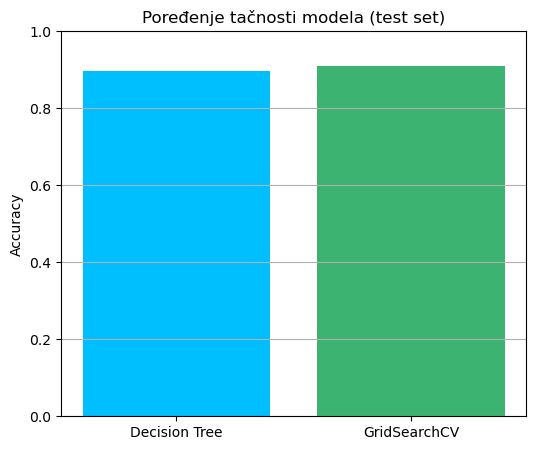

In [25]:
# Accuracy poređenje
acc_dtc = accuracy_score(y_test, dtc.predict(X_test))
acc_grid = accuracy_score(y_test, estimator.best_estimator_.predict(X_test))

plt.figure(figsize=(6, 5))
plt.bar(['Decision Tree', 'GridSearchCV'], [acc_dtc, acc_grid], color=['deepskyblue', 'mediumseagreen'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Poređenje tačnosti modela (test set)")
plt.grid(axis='y')
plt.show()